# Baseline Item-based Collaborative Filtering (Raw Ratings)

편향 보정이나 추가 EDA 없이 **raw rating만 사용하는** Item-based 협업필터링 베이스라인 모델입니다.

구성:
1. 데이터 로드
2. 벡터화 (user-item, item-user 행렬)
3. 아이템 간 유사도 (dot product)
4. 추천 함수 구현 (유저 기준 / 영화 기준)
5. 예측 함수 구현
6. 예측용 테스트 데이터 추출
7. 예측 평점 조인
8. MAE / MSE / RMSE 성능 평가


## 1. 데이터 로드

In [7]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import display

# 데이터 경로 설정 (필요시 수정)
DATA_DIR = Path("data")

MOVIE_DATA_PATH = DATA_DIR / "movies_refined.csv"
RATING_DATA_PATH = DATA_DIR / "ratings_refined.csv"

print("MOVIE_DATA_PATH:", MOVIE_DATA_PATH)
print("RATING_DATA_PATH:", RATING_DATA_PATH)

# CSV 로드
movies_df = pd.read_csv(MOVIE_DATA_PATH)
ratings_df = pd.read_csv(RATING_DATA_PATH)

# 타입 정리 (id는 정수, rating은 float)
movies_df["movie_id"] = movies_df["movie_id"].astype(int)
ratings_df["user_id"] = ratings_df["user_id"].astype(int)
ratings_df["movie_id"] = ratings_df["movie_id"].astype(int)

print("movies_df shape:", movies_df.shape)
print("ratings_df shape:", ratings_df.shape)

display(movies_df.head())
display(ratings_df.head())

MOVIE_DATA_PATH: data/movies_refined.csv
RATING_DATA_PATH: data/ratings_refined.csv
movies_df shape: (9703, 4)
ratings_df shape: (100785, 4)


,movie_id,title,year,genres
0,1,Toy Story (1995),1995,Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),1995,Adventure Children Fantasy
2,3,Grumpier Old Men (1995),1995,Comedy Romance
3,4,Waiting to Exhale (1995),1995,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),1995,Comedy


,user_id,movie_id,rating,timestamp
0,429,420,2.0,828124615
1,429,222,4.0,828124615
2,429,343,3.0,828124615
3,429,349,3.0,828124615
4,429,351,4.0,828124615


## EDA

=== rating 컬럼 기본 통계 ===


count    100785.000000
mean          3.501573
std           1.042456
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


=== rating 값별 개수 (오름차순) ===


rating
0.5     1368
1.0     2809
1.5     1791
2.0     7548
2.5     5544
3.0    20041
3.5    13128
4.0    26809
4.5     8543
5.0    13204
Name: count, dtype: int64

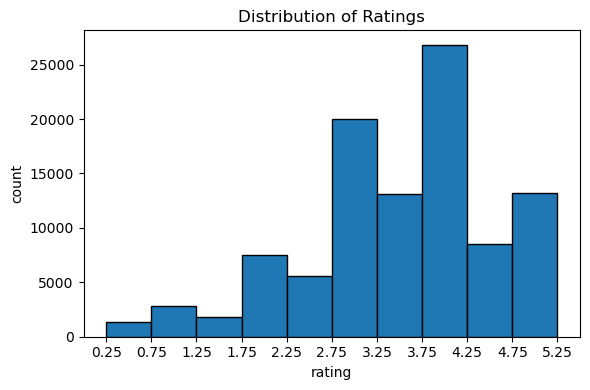


=== rating을 많이 남긴 유저 Top 5 ===


,n_ratings
user_id,
414,2696
599,2474
474,2108
448,1862
274,1346



=== rating을 많이 받은 영화 Top 5 ===


,n_ratings
movie_id,
356,329
318,317
296,307
593,279
2571,278



(user_id, movie_id) 기준 중복 row 수: 0


In [8]:
# === EDA: 평점 분포 / 유저·영화당 rating 개수 / 중복 / 연도 분포 ===
import matplotlib.pyplot as plt
from IPython.display import display

print("=== rating 컬럼 기본 통계 ===")
display(ratings_df["rating"].describe())

print("\n=== rating 값별 개수 (오름차순) ===")
display(ratings_df["rating"].value_counts().sort_index())

# 히스토그램
plt.figure(figsize=(6, 4))
bins = np.arange(ratings_df["rating"].min() - 0.25,
                 ratings_df["rating"].max() + 0.5, 0.5)
plt.hist(ratings_df["rating"], bins=bins, edgecolor="black")
plt.xticks(bins)
plt.title("Distribution of Ratings")
plt.xlabel("rating")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# 한 유저가 남긴 rating 개수
user_rating_counts = ratings_df.groupby("user_id")["rating"].size()
# 한 영화가 받은 rating 개수
movie_rating_counts = ratings_df.groupby("movie_id")["rating"].size()

print("\n=== rating을 많이 남긴 유저 Top 5 ===")
display(
    user_rating_counts.sort_values(ascending=False)
    .head()
    .to_frame(name="n_ratings")
)

print("\n=== rating을 많이 받은 영화 Top 5 ===")
display(
    movie_rating_counts.sort_values(ascending=False)
    .head()
    .to_frame(name="n_ratings")
)

# (user_id, movie_id) 기준 중복 여부 확인
dup_mask = ratings_df.duplicated(subset=["user_id", "movie_id"], keep=False)
dup_count = dup_mask.sum()
print(f"\n(user_id, movie_id) 기준 중복 row 수: {dup_count}")
if dup_count > 0:
    display(ratings_df[dup_mask].head())


## 평점 편향 보정

In [9]:
# === 평점 편향 보정: 유저별 평균 기준 중심화 rating_centered 생성 ===

# 1) 유저별 평균 평점
user_mean = (
    ratings_df
    .groupby("user_id")["rating"]
    .mean()
    .rename("user_mean_rating")
)

# 2) ratings_df에 유저 평균 붙이기
ratings_df = ratings_df.merge(user_mean, on="user_id", how="left")

# 3) "평균에서 얼마나 벗어났는지"를 나타내는 중심화 평점
ratings_df["rating_centered"] = ratings_df["rating"] - ratings_df["user_mean_rating"]

print("\n=== rating + user_mean + rating_centered 샘플 ===")
display(
    ratings_df[["user_id", "movie_id", "rating", "user_mean_rating", "rating_centered"]]
    .head()
)



=== rating + user_mean + rating_centered 샘플 ===


,user_id,movie_id,rating,user_mean_rating,rating_centered
0,429,420,2.0,3.982759,-1.982759
1,429,222,4.0,3.982759,0.017241
2,429,343,3.0,3.982759,-0.982759
3,429,349,3.0,3.982759,-0.982759
4,429,351,4.0,3.982759,0.017241


## 2. 벡터화: user-item / item-user 행렬 만들기

In [10]:
# 영화-유저 평점 테이블 (title, genres 포함) - 분석 및 평가용
movie_ratings_df = pd.merge(
    ratings_df,
    movies_df[["movie_id", "title", "genres"]],
    on="movie_id",
    how="left",
)

print("movie_ratings_df shape:", movie_ratings_df.shape)
display(movie_ratings_df.head())

# user_id × movie_id 행렬 (값 = rating_centered)
#  - index: user_id
#  - columns: movie_id
#  - 값: 각 유저의 "평균 대비 편차" 평점
user_item_matrix = movie_ratings_df.pivot_table(
    values="rating_centered",
    index="user_id",
    columns="movie_id",
    fill_value=0.0,  # 안 본 영화는 0 (편향 없음)
)

print("user_item_matrix shape:", user_item_matrix.shape)
display(user_item_matrix.head())

# item-user 행렬 (영화 × 유저)
item_user_matrix = user_item_matrix.T

item_ids = item_user_matrix.index.to_numpy()    # 영화 ID 순서
user_ids = item_user_matrix.columns.to_numpy()  # 유저 ID 순서

item_matrix = item_user_matrix.to_numpy()

print("item_user_matrix shape:", item_user_matrix.shape)


movie_ratings_df shape: (100785, 8)


,user_id,movie_id,rating,timestamp,user_mean_rating,rating_centered,title,genres
0,429,420,2.0,828124615,3.982759,-1.982759,Beverly Hills Cop III (1994),Action Comedy Crime Thriller
1,429,222,4.0,828124615,3.982759,0.017241,Circle of Friends (1995),Drama Romance
2,429,343,3.0,828124615,3.982759,-0.982759,"Baby-Sitters Club, The (1995)",Children
3,429,349,3.0,828124615,3.982759,-0.982759,Clear and Present Danger (1994),Action Crime Drama Thriller
4,429,351,4.0,828124615,3.982759,0.017241,"Corrina, Corrina (1994)",Comedy Drama Romance


user_item_matrix shape: (610, 9685)


movie_id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
user_id,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,0.0,-0.366379,0.0,0.0,-0.366379,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.363636,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


item_user_matrix shape: (9685, 610)


## 3. 아이템 간 유사도 (dot product 기반 item-item similarity)

In [11]:
# item-item 유사도 행렬 (dot product)
#  - sim[i, j] = 영화 i 벡터와 영화 j 벡터의 내적
item_sim_matrix = np.dot(item_matrix, item_matrix.T)

# 확인용 DataFrame (index/columns = movie_id)
item_sim_df = pd.DataFrame(
    item_sim_matrix,
    index=item_ids,
    columns=item_ids,
)

print("item_sim_matrix shape:", item_sim_matrix.shape)
item_sim_df.iloc[:5, :5]

item_sim_matrix shape: (9685, 9685)


,1,2,3,4,5
1,152.777324,5.849204,4.101075,-1.459290,-11.276642
2,5.849204,59.337005,2.806498,-2.686628,4.097338
3,4.101075,2.806498,41.923204,-0.743590,4.221411
4,-1.459290,-2.686628,-0.743590,10.649285,0.464744
5,-11.276642,4.097338,4.221411,0.464744,42.176181


## 4. 추천 함수 구현 (유저 기준 / 영화 기준)

(1) 유저 기준 추천

In [12]:
def recommend_for_user_baseline(
    target_user_id: int,
    top_n: int = 10,
):
    """
    편향 보정 없는 baseline item-based CF:
    - user-item 행렬의 raw rating 사용
    - item-item dot product 유사도 사용
    - 이미 본 영화는 추천에서 제외
    반환값: (추천 결과 DataFrame, 이미 본 영화 DataFrame)
    """
    if target_user_id not in user_item_matrix.index:
        print(f"[WARN] user_id {target_user_id} 는 user_item_matrix에 없습니다.")
        return (
            pd.DataFrame(columns=["movie_id", "score", "title", "genres"]),
            pd.DataFrame(columns=["movie_id", "rating", "title", "genres"]),
        )
    
    # 1) 해당 유저의 평점 벡터 (index=movie_id)
    user_ratings = user_item_matrix.loc[target_user_id]
    
    # 2) numpy 벡터로 변환 (영화 순서 = item_ids와 맞추기)
    user_vector = user_ratings.reindex(item_ids, fill_value=0.0).to_numpy()
    
    # 3) dot-product 기반 점수 계산
    scores = np.dot(user_vector, item_sim_matrix)  # shape: (n_items,)
    
    # 4) 이미 본 영화는 추천에서 제외
    already_rated_mask = user_ratings.reindex(
        item_ids,
        fill_value=0.0,
    ).to_numpy() != 0.0
    
    scores_filtered = scores.copy()
    scores_filtered[already_rated_mask] = -np.inf
    
    # 5) 추천 후보 수 확인
    n_candidates = np.isfinite(scores_filtered).sum()
    if n_candidates == 0:
        print("[INFO] 추천할 수 있는 영화가 없습니다.")
        rec_df = pd.DataFrame(columns=["movie_id", "score", "title", "genres"])
    else:
        n_top = min(top_n, n_candidates)
        top_indices = np.argpartition(-scores_filtered, n_top - 1)[:n_top]
        top_indices = top_indices[np.argsort(-scores_filtered[top_indices])]
        
        top_movie_ids = item_ids[top_indices]
        top_scores = scores_filtered[top_indices]
        
        rec_df = (
            pd.DataFrame({"movie_id": top_movie_ids, "score": top_scores})
            .merge(movies_df, on="movie_id", how="left")
            .reset_index(drop=True)
        )
    
    # 6) 해당 유저가 이미 본 영화 리스트 (raw rating 기준)
    user_seen_df = (
        movie_ratings_df[movie_ratings_df["user_id"] == target_user_id]
        [["movie_id", "title", "rating"]]
        .sort_values("rating", ascending=False)
        .reset_index(drop=True)
    )
    
    print(f"=== [Baseline] user_id {target_user_id} 가 이미 평가한 영화들 (상위 20개) ===")
    display(user_seen_df.head(20))
    
    print(f"\n=== [Baseline] user_id {target_user_id} 에게 추천하는 영화 Top {top_n} ===")
    display(rec_df)
    
    return rec_df, user_seen_df

(2) 영화 기준 추천

In [13]:
def recommend_similar_movies_baseline(
    target_movie_id: int,
    top_n: int = 10,
    include_self: bool = False,
):
    """
    편향 보정 없는 baseline item-item CF:
    - item-item dot product 유사도 사용
    - 특정 movie_id와 비슷한 영화 추천
    """
    if target_movie_id not in item_ids:
        print(f"[WARN] movie_id {target_movie_id} 는 item_ids에 없습니다.")
        return pd.DataFrame(columns=["movie_id", "similarity", "title", "genres"])
    
    target_idx = np.where(item_ids == target_movie_id)[0][0]
    sims = item_sim_matrix[target_idx].copy()
    
    if not include_self:
        sims[target_idx] = -np.inf
    
    n_candidates = np.isfinite(sims).sum()
    if n_candidates == 0:
        print("[INFO] 유사한 영화를 찾을 수 없습니다.")
        return pd.DataFrame(columns=["movie_id", "similarity", "title", "genres"])
    
    n_top = min(top_n, n_candidates)
    top_indices = np.argpartition(-sims, n_top - 1)[:n_top]
    top_indices = top_indices[np.argsort(-sims[top_indices])]
    
    top_movie_ids = item_ids[top_indices]
    top_scores = sims[top_indices]
    
    sim_df = (
        pd.DataFrame({"movie_id": top_movie_ids, "similarity": top_scores})
        .merge(movies_df, on="movie_id", how="left")
        .reset_index(drop=True)
    )
    
    return sim_df

(3) 한 사용자가 본 영화 중 임의로 1편을 골라서 해당 영화와 유사한 영화 top n개를 추천

In [14]:
from IPython.display import display
import numpy as np
import pandas as pd

def recommend_from_random_watched_movie(
    target_user_id: int,
    top_n: int = 10,
    random_state: int | None = None,
):
    """
    한 사용자가 본 영화 목록을 먼저 보여주고,
    그 중 임의로 1편을 골라서 해당 영화와 유사한 영화 top_n개를 추천하는 함수.

    - movie_ratings_df: user_id, movie_id, title, rating 이 들어있는 DF
    - item_sim_matrix: movie_id 기준 item-item 유사도 (dot product)
    - item_ids: item_sim_matrix의 movie_id 순서
    - movies_df: movie_id, title, genres 등 메타 정보
    """

    # user_id를 int로 캐스팅 (이미 int면 그대로, string "1"이면 1로)
    try:
        uid = int(target_user_id)
    except ValueError:
        uid = target_user_id  # 혹시 정수 변환이 안 되면 그대로 사용

    # 1) 해당 유저가 본 영화 목록 가져오기
    user_movies = movie_ratings_df[movie_ratings_df["user_id"] == uid].copy()

    if user_movies.empty:
        print(f"[WARN] user_id {target_user_id} 에 대한 시청 기록이 없습니다.")
        return None, pd.DataFrame(), pd.DataFrame()

    # 필요하면 movies_df에서 장르 정보 붙이기
    if "genres" not in user_movies.columns:
        user_movies = user_movies.merge(
            movies_df[["movie_id", "genres"]],
            on="movie_id",
            how="left",
        )

    # 평점 순으로 정렬해서 보기 좋게
    user_movies = user_movies.sort_values("rating", ascending=False)

    print(f"=== user_id {uid} 가 본 영화 목록 (평점 순, 상위 20개) ===")
    display(user_movies[["movie_id", "title", "genres", "rating"]].head(20))

    # 2) 그 중 임의의 영화 1편 선택
    if random_state is not None:
        chosen_row = user_movies.sample(n=1, random_state=random_state).iloc[0]
    else:
        chosen_row = user_movies.sample(n=1).iloc[0]

    # → if/else 밖에서 공통 처리
    chosen_movie_id = int(chosen_row["movie_id"])
    chosen_title = chosen_row["title"]
    chosen_genres = chosen_row["genres"]
    chosen_rating = chosen_row["rating"]

    print("\n=== 기준이 되는 영화 (랜덤 선택) ===")
    display(
        chosen_row[["movie_id", "title", "genres", "rating"]]
        .to_frame()
        .T
        .reset_index(drop=True)
    )


    # 3) 이 영화와 유사한 영화 top_n 추천
    if chosen_movie_id not in item_ids:
        print("[WARN] 선택된 영화가 item_ids에 없습니다. 유사도 계산 불가.")
        return chosen_row, user_movies, pd.DataFrame()

    # similarity vector 꺼내기
    idx = np.where(item_ids == chosen_movie_id)[0][0]
    sims = item_sim_matrix[idx].copy()

    # 자기 자신은 제외
    sims[idx] = -np.inf

    # 유효 후보 개수
    n_candidates = np.isfinite(sims).sum()
    if n_candidates == 0:
        print("[INFO] 유사한 영화를 찾을 수 없습니다.")
        return chosen_row, user_movies, pd.DataFrame()

    n_top = min(top_n, n_candidates)

    # 상위 top_n index 뽑기
    top_idx = np.argpartition(-sims, n_top - 1)[:n_top]
    top_idx = top_idx[np.argsort(-sims[top_idx])]

    rec_movie_ids = item_ids[top_idx]
    rec_scores = sims[top_idx]

    # 영화 메타데이터 붙이기
    rec_df = (
        pd.DataFrame({"movie_id": rec_movie_ids, "similarity": rec_scores})
        .merge(movies_df, on="movie_id", how="left")
        [["movie_id", "title", "genres", "similarity"]]
        .reset_index(drop=True)
    )

    print(f"\n=== '{chosen_title}' 와 유사한 영화 Top {top_n} ===")
    display(rec_df)

    # 기준 영화 1편 정보, 해당 유저의 전체 시청 목록, 추천 결과를 모두 반환
    return chosen_row, user_movies, rec_df


In [15]:
# === (선택) 예시 실행 ===
# recommend_for_user_baseline(1, top_n=10)
# recommend_similar_movies_baseline(1, top_n=10)
recommend_from_random_watched_movie(1, top_n=10, random_state=42)

=== user_id 1 가 본 영화 목록 (평점 순, 상위 20개) ===


,movie_id,title,genres,rating
15203,1049,"Ghost and the Darkness, The (1996)",Action Adventure,5.0
15193,3441,Red Dawn (1984),Action Drama War,5.0
15255,1089,Reservoir Dogs (1992),Crime Mystery Thriller,5.0
15256,1617,L.A. Confidential (1997),Crime Film-Noir Mystery Thriller,5.0
15188,1275,Highlander (1986),Action Adventure Fantasy,5.0
15187,1573,Face/Off (1997),Action Crime Drama Thriller,5.0
15259,2580,Go (1999),Comedy Crime,5.0
15261,1804,"Newton Boys, The (1998)",Crime Drama,5.0
15184,2991,Live and Let Die (1973),Action Adventure Thriller,5.0
15181,2529,Planet of the Apes (1968),Action Drama Sci-Fi,5.0



=== 기준이 되는 영화 (랜덤 선택) ===


,movie_id,title,genres,rating
0,1030,Pete's Dragon (1977),Adventure Animation Children Musical,3.0



=== 'Pete's Dragon (1977)' 와 유사한 영화 Top 10 ===


,movie_id,title,genres,similarity
0,2471,Crocodile Dundee II (1988),Action Adventure Comedy,10.381305
1,2468,Jumpin' Jack Flash (1986),Action Comedy Romance Thriller,10.153796
2,7,Sabrina (1995),Comedy Romance,10.074285
3,1544,"Lost World: Jurassic Park, The (1997)",Action Adventure Sci-Fi Thriller,9.763811
4,485,Last Action Hero (1993),Action Adventure Comedy Fantasy,9.140392
5,2411,Rocky IV (1985),Action Drama,8.617185
6,3247,Sister Act (1992),Comedy Crime,8.563806
7,5481,Austin Powers in Goldmember (2002),Comedy,8.432672
8,1917,Armageddon (1998),Action Romance Sci-Fi Thriller,8.235874
9,2088,Popeye (1980),Adventure Comedy Musical,8.059699


(user_id                                                1
 movie_id                                            1030
 rating                                               3.0
 timestamp                                      964982903
 user_mean_rating                                4.366379
 rating_centered                                -1.366379
 title                               Pete's Dragon (1977)
 genres              Adventure Animation Children Musical
 Name: 15249, dtype: object,
        user_id  movie_id  rating  timestamp  user_mean_rating  \
 15203        1      1049     5.0  964982400          4.366379   
 15193        1      3441     5.0  964982328          4.366379   
 15255        1      1089     5.0  964982951          4.366379   
 15256        1      1617     5.0  964982951          4.366379   
 15188        1      1275     5.0  964982290          4.366379   
 ...        ...       ...     ...        ...               ...   
 15150        1      2253     2.0  964981775 

## 5. 예측 함수 (Baseline item-based CF, raw rating)

In [16]:
def predict_rating_item_based_bias(user_id: int, movie_id: int) -> float:
    """
    user bias 보정된 rating_centered + item-based CF로
    (user_id, movie_id)의 원래 평점 스케일(0.5~5.0)을 예측하는 함수.

    - user_item_matrix: 값 = rating_centered
    - item_sim_matrix: rating_centered 기반 item-item dot product 유사도
    - user_mean: 유저별 평균 평점 (user_mean_rating)
    """
    # 1) 존재 여부 체크
    if user_id not in user_item_matrix.index:
        return np.nan
    if movie_id not in item_ids:
        return np.nan

    # 2) 해당 유저의 rating_centered 벡터 (Series, index=movie_id)
    user_vector = user_item_matrix.loc[user_id]

    # 3) target item의 similarity 벡터 (target vs 모든 item)
    target_idx = np.where(item_ids == movie_id)[0][0]
    sims = item_sim_matrix[target_idx]  # shape: (n_items,)

    # 4) 유저가 실제로 본 영화들만 사용 (rating_centered != 0인 곳)
    rated_mask = (user_vector != 0.0).to_numpy()
    sims_rated = sims[rated_mask]
    ratings_centered_rated = user_vector.to_numpy()[rated_mask]

    # train에서 본 영화가 하나도 없으면 예측 불가
    if len(ratings_centered_rated) == 0:
        return np.nan

    # 5) 가중 평균 (dot-product 유사도 기반)
    denom = np.sum(np.abs(sims_rated))
    if denom == 0:
        return np.nan

    pred_centered = np.sum(sims_rated * ratings_centered_rated) / denom

    # 6) 유저 평균을 다시 더해 원래 rating 스케일(0.5~5.0)로 복원
    mu_u = user_mean.loc[user_id]
    pred_rating = mu_u + pred_centered

    # 7) MovieLens 스케일에 맞게 클리핑
    pred_rating = max(0.5, min(5.0, pred_rating))

    return float(pred_rating)


## 6. 예측 정확도 평가용 테스트 데이터 추출

In [17]:
from sklearn.model_selection import train_test_split

# 테스트용 샘플 데이터 추출
#  - movie_ratings_df에서 user_id, movie_id, title, rating만 사용
_, test_data = train_test_split(
    movie_ratings_df[["user_id", "movie_id", "title", "rating"]],
    test_size=20000,
    random_state=1234,
    stratify=movie_ratings_df["user_id"],
)

print("test_data shape:", test_data.shape)
display(test_data.head())

test_data shape: (20000, 4)


,user_id,movie_id,title,rating
62316,464,7481,Enemy Mine (1985),4.5
60208,590,4447,Legally Blonde (2001),3.0
24643,135,1653,Gattaca (1997),5.0
30554,288,2054,"Honey, I Shrunk the Kids (1989)",3.5
99865,258,4995,"Beautiful Mind, A (2001)",5.0


## 7. 테스트 데이터에 대한 예측 평점 계산 및 조인

In [19]:
# 테스트 데이터의 각 (user_id, movie_id)에 대해 예측 평점 계산
pred_rows = []

for row in test_data.itertuples():
    u = row.user_id
    m = row.movie_id
    t = row.title

    pred = predict_rating_item_based_bias(u, m)  # ✅ 편향 보정 모델 사용
    pred_rows.append((u, t, pred))

all_pred_df = pd.DataFrame(pred_rows, columns=["user_id", "title", "pred_rating"])

print("all_pred_df shape:", all_pred_df.shape)
display(all_pred_df.head())

# 예측 평점 조인
test_data = pd.merge(test_data, all_pred_df, on=["user_id", "title"], how="left")
display(test_data.head())


all_pred_df shape: (20000, 3)


,user_id,title,pred_rating
0,464,Enemy Mine (1985),4.709520
1,590,Legally Blonde (2001),2.888354
2,135,Gattaca (1997),4.475372
3,288,"Honey, I Shrunk the Kids (1989)",2.810959
4,258,"Beautiful Mind, A (2001)",4.799427


,user_id,movie_id,title,rating,pred_rating
0,464,7481,Enemy Mine (1985),4.5,4.709520
1,590,4447,Legally Blonde (2001),3.0,2.888354
2,135,1653,Gattaca (1997),5.0,4.475372
3,288,2054,"Honey, I Shrunk the Kids (1989)",3.5,2.810959
4,258,4995,"Beautiful Mind, A (2001)",5.0,4.799427


## 8. MAE / MSE / RMSE 성능 평가

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) 예측값이 NaN이 아닌 샘플만 평가에 사용
valid_mask = test_data["pred_rating"].notna()
eval_df = test_data[valid_mask].copy()

print(
    f"전체 test 개수: {len(test_data)}, "
    f"평가에 사용된 개수: {len(eval_df)} "
    f"(coverage={len(eval_df) / len(test_data):.3f})"
)

# 2) 실제 평점과 예측 평점을 배열로 변환
true_y = eval_df["rating"].to_numpy()
pred_y = eval_df["pred_rating"].to_numpy()

# 3) MAE, MSE, RMSE 계산
mae = mean_absolute_error(y_true=true_y, y_pred=pred_y)
mse = mean_squared_error(y_true=true_y, y_pred=pred_y)
rmse = np.sqrt(mse)

print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")


전체 test 개수: 20000, 평가에 사용된 개수: 19996 (coverage=1.000)
MAE  : 0.4167
MSE  : 0.3044
RMSE : 0.5518
